In [45]:
import shap
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV # Import RandomizedSearchCV



In [6]:
# Load the dataset
file_path = '/content/drive/MyDrive/SAdata_allMeasures.csv'
data = pd.read_csv(file_path)
print(data.shape)
print(data.head())

(1054, 29)
   age  gender  yearDriving  drivingFrequency  temp_length  temp_decisiontime  \
0   26       1           20                 1           12            4.80219   
1   26       1           20                 1            6            4.91667   
2   26       1           20                 1            1            2.21716   
3   26       1           20                 1            3            2.63056   
4   26       1           20                 1            9            2.42632   

   temp_decision_made  temp_correct_decision  temp_danger  temp_difficulty  \
0                   4                      2           20               89   
1                   1                      2           10               99   
2                   2                      2           99               99   
3                   1                      2            9               79   
4                   1                      2            9               96   

   ...    fMax  backMirror  leftM

2.2

In [8]:
# Basic dataset info
print(data.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    1054 non-null   int64  
 1   gender                 1054 non-null   int64  
 2   yearDriving            1054 non-null   int64  
 3   drivingFrequency       1054 non-null   int64  
 4   temp_length            1054 non-null   int64  
 5   temp_decisiontime      1054 non-null   float64
 6   temp_decision_made     1054 non-null   int64  
 7   temp_correct_decision  1054 non-null   int64  
 8   temp_danger            1054 non-null   int64  
 9   temp_difficulty        1054 non-null   int64  
 10  CarPlacedLeft          1054 non-null   int64  
 11  CarPlacedRight         1054 non-null   int64  
 12  numS                   1054 non-null   int64  
 13  sAmpMean               1054 non-null   float64
 14  sAmpStd                1054 non-null   float64
 15  sAmp

In [10]:
print(data.describe())


               age       gender  yearDriving  drivingFrequency  temp_length  \
count  1054.000000  1054.000000  1054.000000       1054.000000  1054.000000   
mean     24.222960     1.093928    18.751423          2.563567     6.328273   
std       1.815467     0.291867     1.370865          1.521371     4.919332   
min      22.000000     1.000000    16.000000          0.000000     1.000000   
25%      23.000000     1.000000    18.000000          1.250000     3.000000   
50%      24.000000     1.000000    18.000000          3.000000     6.000000   
75%      25.750000     1.000000    19.000000          4.000000     9.000000   
max      29.000000     2.000000    22.000000          5.000000    20.000000   

       temp_decisiontime  temp_decision_made  temp_correct_decision  \
count        1054.000000         1054.000000            1054.000000   
mean            2.098773            2.129981               4.552182   
std             0.900854            1.159294               6.932357   
min 

In [12]:
# Check for missing values
print(data.isnull().sum())


age                      0
gender                   0
yearDriving              0
drivingFrequency         0
temp_length              0
temp_decisiontime        0
temp_decision_made       0
temp_correct_decision    0
temp_danger              0
temp_difficulty          0
CarPlacedLeft            0
CarPlacedRight           0
numS                     0
sAmpMean                 0
sAmpStd                  0
sAmpMax                  0
numF                     0
fMean                    0
fStd                     0
fMax                     0
backMirror               0
leftMirror               0
rightMirror              0
road                     0
sky                      0
pupilChange              0
pupilMean                0
pupilStd                 0
Y                        0
dtype: int64


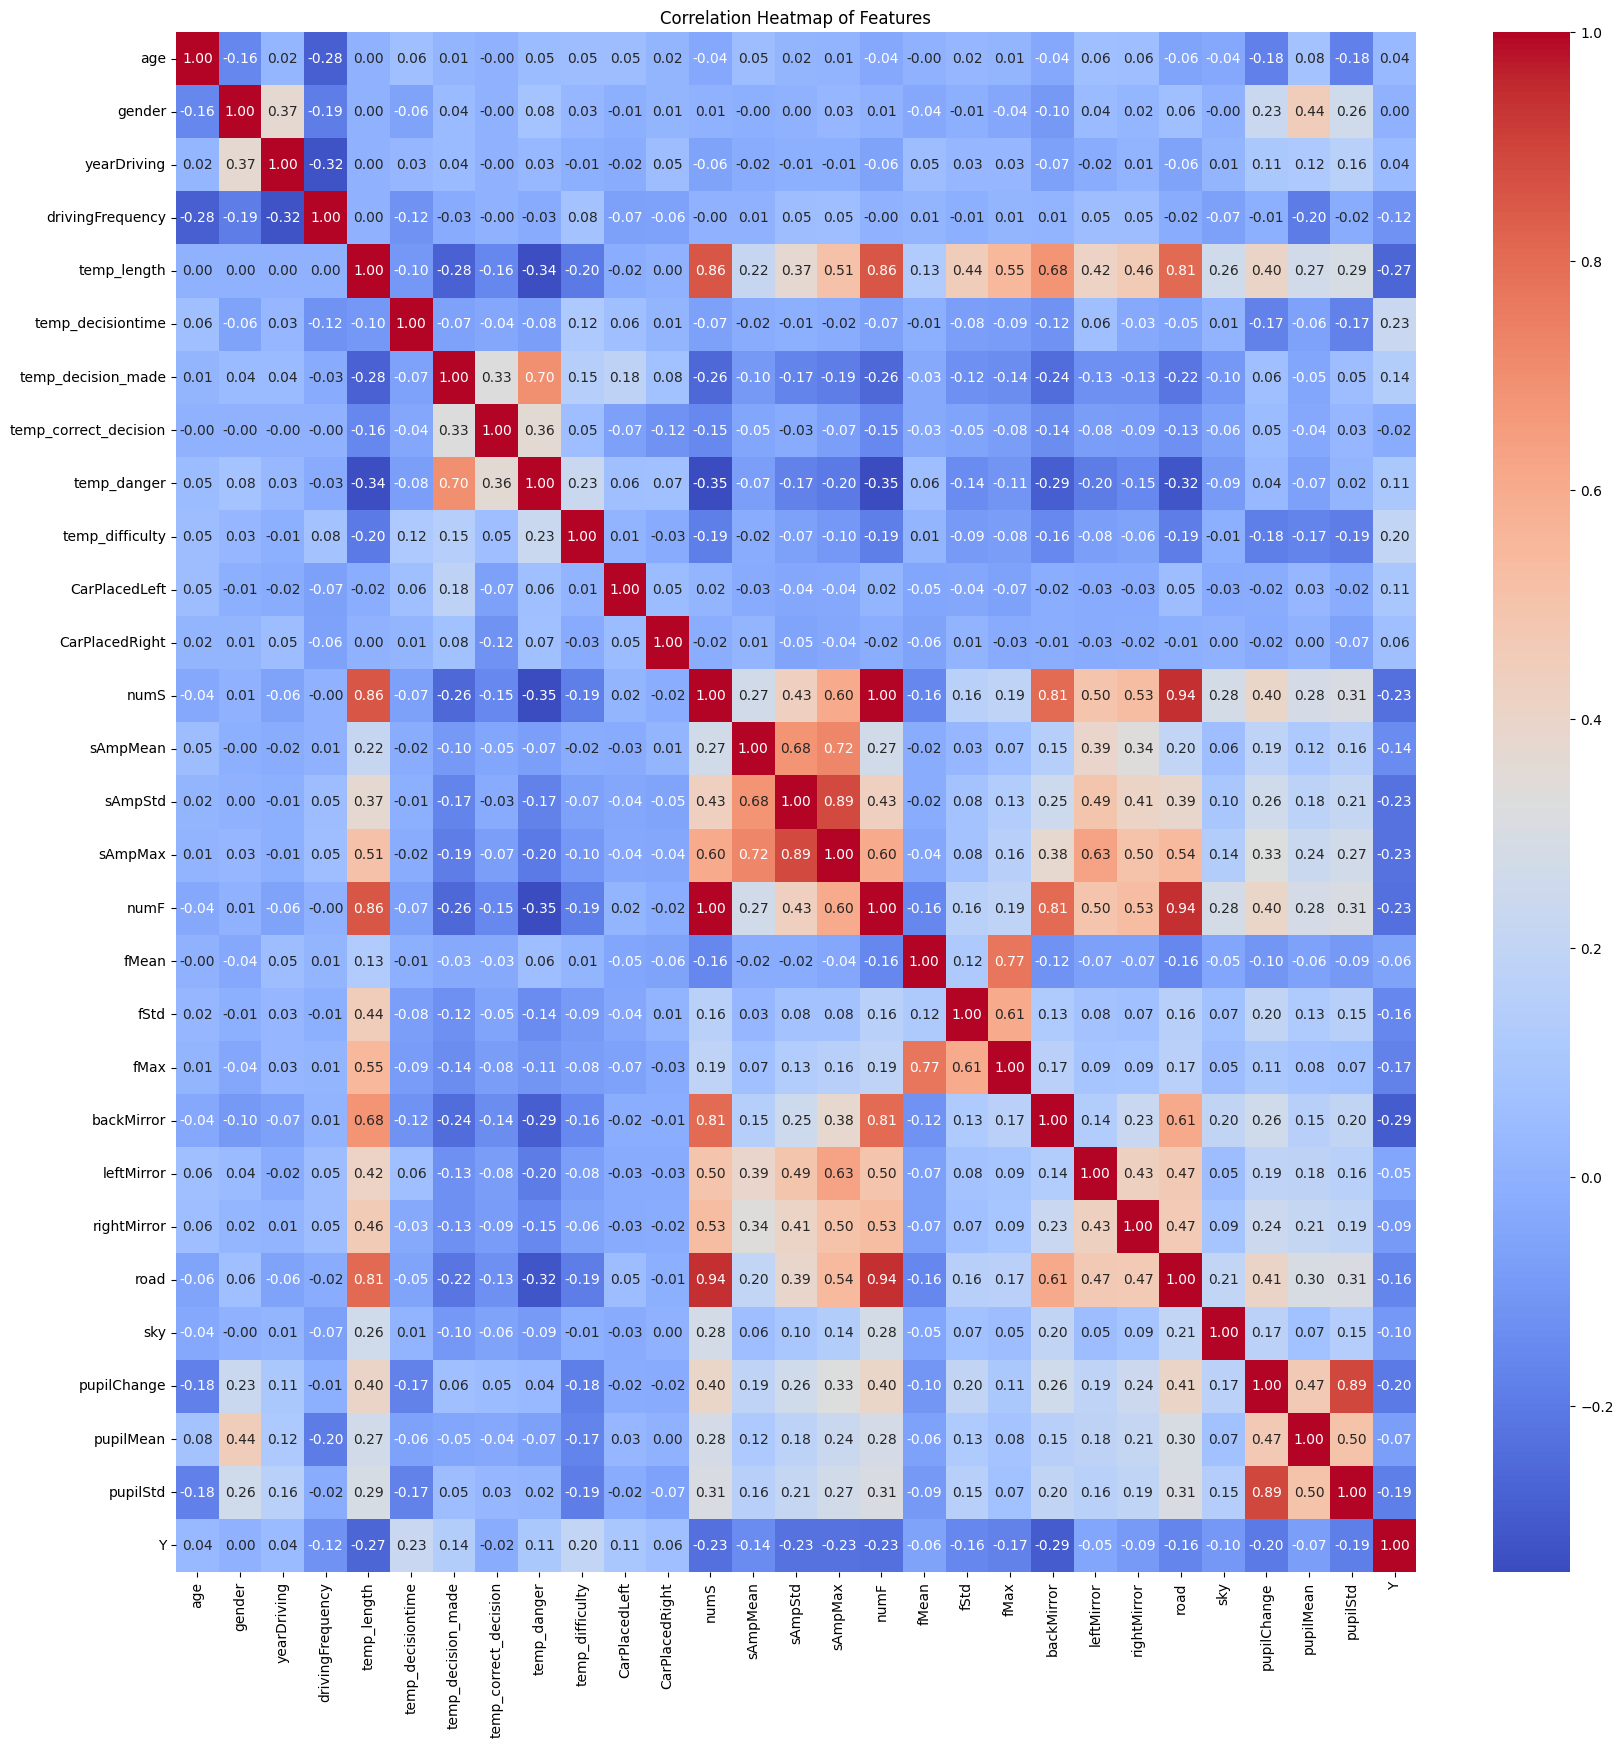

In [24]:
# Plotting correlation heatmap to understand feature relationships
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()


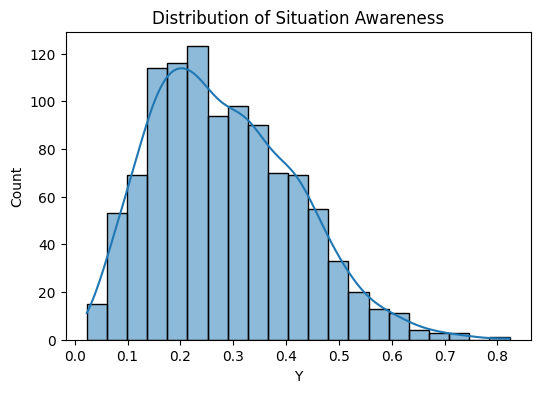

In [26]:
# Distribution of target variable
plt.figure(figsize=(6, 4))
sns.histplot(data['Y'], kde=True)
plt.title('Distribution of Situation Awareness')
plt.show()

2.3)

2.4)

In [29]:
# Define target and features
target_column = 'Y'  # The target variable
categorical_features = ['gender', 'temp_decision_made', 'CarPlacedLeft', 'CarPlacedRight']
numerical_features = [col for col in data.columns if col not in categorical_features + [target_column]]


In [48]:
# Feature scaling for numeric features
scaler = StandardScaler()
scaled_data = data.copy()
scaled_data[numerical_features] = scaler.fit_transform(scaled_data[numerical_features])  # Assuming last column is target

# Train-test split
X = scaled_data.drop(columns=[target_column])  # Features # Drop only the target column
y = scaled_data[target_column]  # Target variable

# Define categorical transformer using OneHotEncoder
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Define OneHotEncoder

# ColumnTransformer applies OneHotEncoder to the categorical columns and leaves the numerical features untouched
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features) # Apply OneHotEncoder to categorical columns
    ], remainder='passthrough')  # Leave numerical features as they are
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2.5)

# Model Implementation LightGbm

In [56]:
# Train LightGBM Model
lgb_params = {
    'objective': 'regression',
    'metric': ['rmse', 'l2'],
    'learning_rate': 0.1,
    'num_leaves': 50,
    'random_state': 42,
    'subsample': 1.0,
    'reg_lambda': 0,
    'reg_alpha': 1,
    'n_estimators': 100,
    'min_child_samples': 10,
    'max_depth': 3,
    'learning_rate': 0.2,
    'colsample_bytree': 0.7,
    'bagging_fraction': 0.8,

}


train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
evals_result_lgb = {}

lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'eval'],
    callbacks=[lgb.record_evaluation(evals_result_lgb)]
)

# Evaluate performance
y_pred_lgb = lgb_model.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)

print(f'RMSE (LightGBM): {rmse_lgb}')
print(f'MAE (LightGBM): {mae_lgb}')


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2906
[LightGBM] [Info] Number of data points in the train set: 843, number of used features: 28
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Start training from score 0.286042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

 RandomizedSearchCV

In [49]:
# Use the same parameter grid
param_dist_lgb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 50, 70],
    'max_depth': [3, 5, 7, -1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_lambda': [0, 0.1, 1],
    'reg_alpha': [0, 0.1, 1],
    'min_child_samples': [10, 20, 30]
}

# Initialize LightGBM model
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42)

# RandomizedSearchCV for LightGBM
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist_lgb,
    n_iter=50,  # Limit to 50 random combinations
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
# Apply the preprocessor to X_train and X_test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Fit the model
random_search_lgb.fit(X_train_processed, y_train)

# Best parameters and score
print("Best parameters for LightGBM:", random_search_lgb.best_params_)
print("Best RMSE (negative MSE):", (-random_search_lgb.best_score_)**0.5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2913
[LightGBM] [Info] Number of data points in the train set: 843, number of used features: 35
[LightGBM] [Info] Start training from score 0.286042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

#  SHAP for LightGBM model

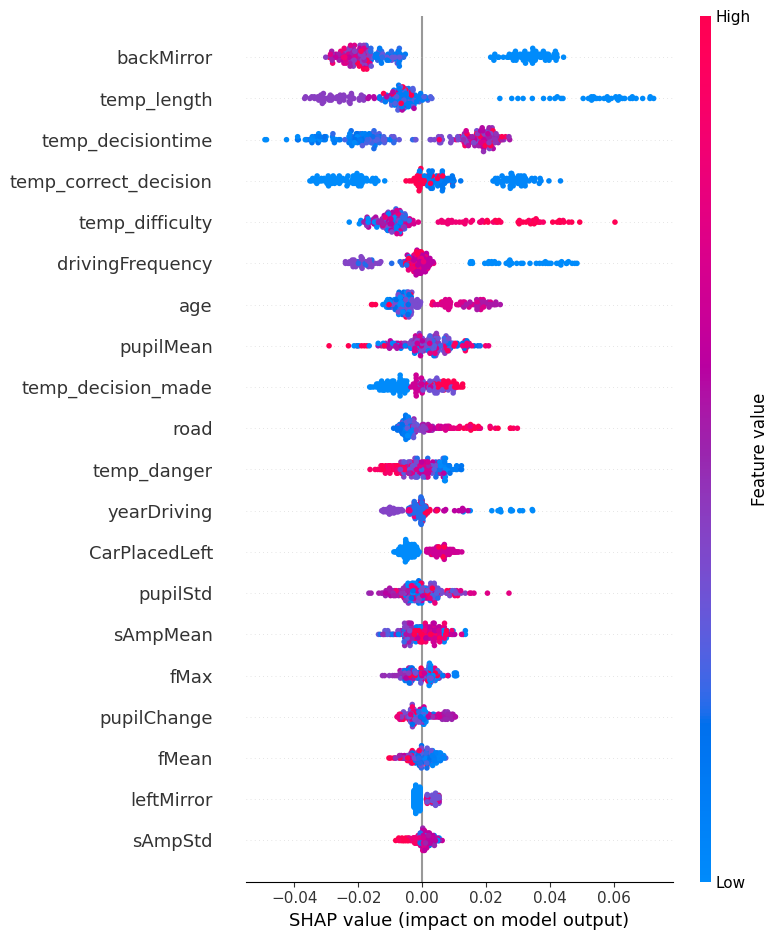

In [57]:
import shap
# SHAP for LightGBM model
explainer_lgb = shap.TreeExplainer(lgb_model)

# Generate SHAP values for the test set
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values_lgb, X_test)


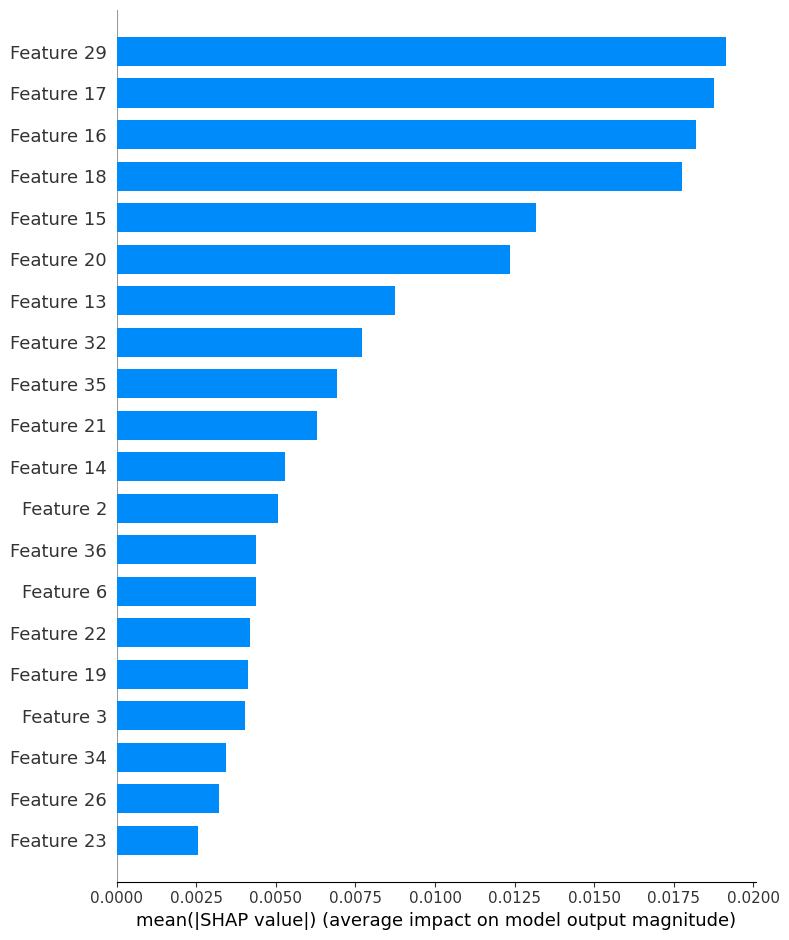

In [66]:
import shap

# Get the best model from RandomizedSearchCV
best_lgb_model = random_search_lgb.best_estimator_

# Create a new TreeExplainer with the best model
explainer_lgb = shap.TreeExplainer(best_lgb_model)

# Calculate SHAP values using the processed data (X_test_processed)
shap_values_lgb = explainer_lgb.shap_values(X_test_processed)

# Plot the SHAP summary plot
shap.summary_plot(shap_values_lgb, X_test_processed, plot_type="bar")


Model Implementation Linear Regression

In [61]:
# Apply the preprocessor to X_train and X_test before fitting the lr_model
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Train Linear Regression Model using the processed data
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)  # Fit with transformed data

# Evaluate performance
y_pred_lr = lr_model.predict(X_test_processed)  # Predict with transformed data
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print(f'RMSE (Linear Regression): {rmse_lr}')
print(f'MAE (Linear Regression): {mae_lr}')

RMSE (Linear Regression): 0.11371382018418442
MAE (Linear Regression): 0.08995746487319697


  0%|          | 0/211 [00:00<?, ?it/s]

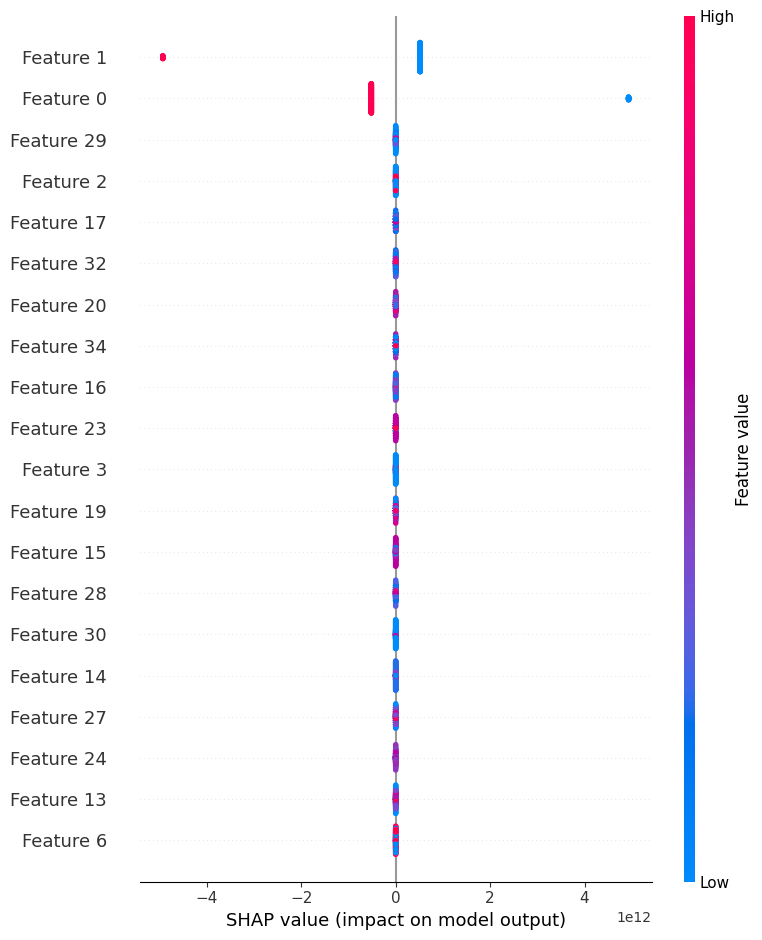

In [62]:
# SHAP for linear regression using KernelExplainer
explainer_lr = shap.KernelExplainer(lr_model.predict, X_train_processed)
shap_values_lr = explainer_lr.shap_values(X_test_processed)

# Plot SHAP summary plot
shap.summary_plot(shap_values_lr, X_test_processed)
